# Group Assignment 3: Spatial Autocorrelation: Los Angeles Toxic Release Sites and Population Size 
In this assignment we look at the location of Toxic Release Sites in Los Angeles, and observe whether there is statistical significance in relation to their placement and population size by Los Angeles census tracts. Our previous map showed that there appeared to be a clustering of toxic release sites in East Los Angeles, this exploration is an attempt to see if this pattern extends when looking at the amuont of toxic releases in proportion to the population size in census tracts. In this assignment I wanted to understand Yoh's lab better, and explore these statistical tools(Morans Plot, Lisa Cluster)  and its implications on our findings. 

I used the LA census tracts information from Census Reporter and the EPA's Toxic Release Inventory data. 



Facilities that report to TRI are typically larger facilities involved in manufacturing, metal mining, electric power generation, chemical manufacturing and hazardous waste treatment

In [1]:
# to read and wrangle data
import pandas as pd

# to create spatial data
import geopandas as gpd

# for basemaps
import contextily as ctx

# For spatial statistics
import esda
from esda.moran import Moran, Moran_Local

import splot
from splot.esda import moran_scatterplot, plot_moran, lisa_cluster,plot_moran_simulation

import libpysal as lps

# Graphics
import matplotlib.pyplot as plt
import plotly.express as px

/opt/conda/lib/python3.9/site-packages/geopandas/_compat.py:106: UserWarning: The Shapely GEOS version (3.9.1-CAPI-1.14.2) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.
  warnings.warn(


I decided I would use census tracts instead of census blocks, there are only 110 Toxic Release sites in Los Angeles and if I did smaller census blocks, there would be many census blocks with no data. 

In [2]:
gdf_tracts = gpd.read_file('data/tracts.geojson')

In [3]:
gdf_tracts

geoid                                   name  B01003001  \
0     14000US06037101110  Census Tract 1011.10, Los Angeles, CA     4283.0   
1     14000US06037101122  Census Tract 1011.22, Los Angeles, CA     3405.0   
2     14000US06037101210  Census Tract 1012.10, Los Angeles, CA     6347.0   
3     14000US06037101220  Census Tract 1012.20, Los Angeles, CA     3702.0   
4     14000US06037101300     Census Tract 1013, Los Angeles, CA     3884.0   
...                  ...                                    ...        ...   
1000  14000US06037980026  Census Tract 9800.26, Los Angeles, CA       26.0   
1001  14000US06037980028  Census Tract 9800.28, Los Angeles, CA        0.0   
1002  14000US06037980031  Census Tract 9800.31, Los Angeles, CA     1175.0   
1003  14000US06037990200     Census Tract 9902, Los Angeles, CA        0.0   
1004      16000US0644000                        Los Angeles, CA  3966936.0   

      B01003001, Error                                           geometry  
0                443.0  MULTIPOLYGON (((-118.30229 34.25870, -118.3009...  
1                334.0  MULTIPOLYGON (((-118.30334 34.27371, -118.3033...  
2                484.0  MULTIPOLYGON (((-118.29945 34.25598, -118.2979...  
3                276.0  MULTIPOLYGON (((-118.28593 34.25227, -118.2859...  
4                394.0  MULTIPOLYGON (((-118.27822 34.25068, -118.2782...  
...                ...                                                ...  
1000              18.0  MULTIPOLYGON (((-118.35173 34.28034, -118.3517...  
1001              12.0  MULTIPOLYGON (((-118.45246 33.94315, -118.4464...  
1002             178.0  MULTIPOLYGON (((-118.29105 33.75378, -118.2905...  
1003              12.0  MULTIPOLYGON (((-118.63598 34.03255, -118.6325...  
1004              82.0  MULTIPOLYGON (((-118.66818 34.18987, -118.6681...  

[1005 rows x 5 columns]

<AxesSubplot:>

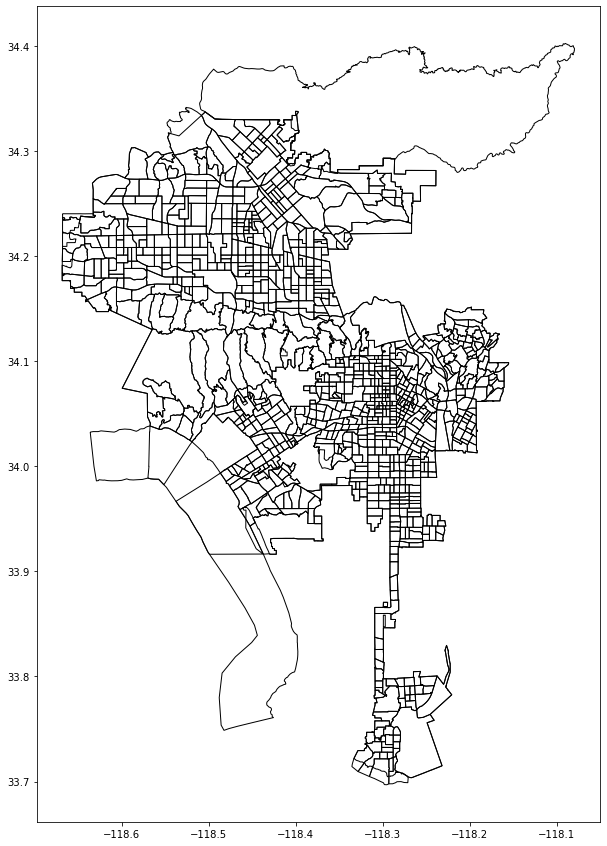

In [4]:
fig,ax = plt.subplots(figsize=(15,15))
gdf_tracts.boundary.plot(ax=ax,color='black',zorder=20,lw=1)

Our map divided into census tracts 

In [5]:
gdf_tracts.head()

geoid                                   name  B01003001  \
0  14000US06037101110  Census Tract 1011.10, Los Angeles, CA     4283.0   
1  14000US06037101122  Census Tract 1011.22, Los Angeles, CA     3405.0   
2  14000US06037101210  Census Tract 1012.10, Los Angeles, CA     6347.0   
3  14000US06037101220  Census Tract 1012.20, Los Angeles, CA     3702.0   
4  14000US06037101300     Census Tract 1013, Los Angeles, CA     3884.0   

   B01003001, Error                                           geometry  
0             443.0  MULTIPOLYGON (((-118.30229 34.25870, -118.3009...  
1             334.0  MULTIPOLYGON (((-118.30334 34.27371, -118.3033...  
2             484.0  MULTIPOLYGON (((-118.29945 34.25598, -118.2979...  
3             276.0  MULTIPOLYGON (((-118.28593 34.25227, -118.2859...  
4             394.0  MULTIPOLYGON (((-118.27822 34.25068, -118.2782...

In [6]:
gdf_tracts.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 1005 entries, 0 to 1004
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   geoid             1005 non-null   object  
 1   name              1005 non-null   object  
 2   B01003001         1005 non-null   float64 
 3   B01003001, Error  1005 non-null   float64 
 4   geometry          1005 non-null   geometry
dtypes: float64(2), geometry(1), object(2)
memory usage: 39.4+ KB


In [49]:
 #Now we clean the data up a little bit so that unwanted values are deleted

In [7]:
# trim the data to the bare minimum columns
gdf_tracts= gdf_tracts[['geoid','B01003001','geometry']]

# rename the columns
gdf_tracts.columns = ['FIPS','TotalPop','geometry']

In [8]:
gdf_tracts.head()

FIPS  TotalPop  \
0  14000US06037101110    4283.0   
1  14000US06037101122    3405.0   
2  14000US06037101210    6347.0   
3  14000US06037101220    3702.0   
4  14000US06037101300    3884.0   

                                            geometry  
0  MULTIPOLYGON (((-118.30229 34.25870, -118.3009...  
1  MULTIPOLYGON (((-118.30334 34.27371, -118.3033...  
2  MULTIPOLYGON (((-118.29945 34.25598, -118.2979...  
3  MULTIPOLYGON (((-118.28593 34.25227, -118.2859...  
4  MULTIPOLYGON (((-118.27822 34.25068, -118.2782...

In [9]:
gdf_tracts.tail()

FIPS   TotalPop  \
1000  14000US06037980026       26.0   
1001  14000US06037980028        0.0   
1002  14000US06037980031     1175.0   
1003  14000US06037990200        0.0   
1004      16000US0644000  3966936.0   

                                               geometry  
1000  MULTIPOLYGON (((-118.35173 34.28034, -118.3517...  
1001  MULTIPOLYGON (((-118.45246 33.94315, -118.4464...  
1002  MULTIPOLYGON (((-118.29105 33.75378, -118.2905...  
1003  MULTIPOLYGON (((-118.63598 34.03255, -118.6325...  
1004  MULTIPOLYGON (((-118.66818 34.18987, -118.6681...

In [10]:
gdf_tracts=gdf_tracts.drop(1004)

In [11]:
gdf_tracts.tail()

FIPS  TotalPop  \
999   14000US06037980024     223.0   
1000  14000US06037980026      26.0   
1001  14000US06037980028       0.0   
1002  14000US06037980031    1175.0   
1003  14000US06037990200       0.0   

                                               geometry  
999   MULTIPOLYGON (((-118.51849 34.18389, -118.5184...  
1000  MULTIPOLYGON (((-118.35173 34.28034, -118.3517...  
1001  MULTIPOLYGON (((-118.45246 33.94315, -118.4464...  
1002  MULTIPOLYGON (((-118.29105 33.75378, -118.2905...  
1003  MULTIPOLYGON (((-118.63598 34.03255, -118.6325...

In [12]:
gdf_tracts.sort_values(by='TotalPop').head(20)

FIPS  TotalPop  \
1003  14000US06037990200       0.0   
1001  14000US06037980028       0.0   
995   14000US06037980020       0.0   
997   14000US06037980022       0.0   
998   14000US06037980023       0.0   
990   14000US06037980009       5.0   
992   14000US06037980014       9.0   
1000  14000US06037980026      26.0   
996   14000US06037980021      33.0   
989   14000US06037980008      68.0   
991   14000US06037980010      95.0   
994   14000US06037980019     138.0   
999   14000US06037980024     223.0   
988   14000US06037930200     461.0   
993   14000US06037980015     671.0   
934   14000US06037277400     909.0   
987   14000US06037701100    1101.0   
915   14000US06037275101    1161.0   
1002  14000US06037980031    1175.0   
851   14000US06037265410    1495.0   

                                               geometry  
1003  MULTIPOLYGON (((-118.63598 34.03255, -118.6325...  
1001  MULTIPOLYGON (((-118.45246 33.94315, -118.4464...  
995   MULTIPOLYGON (((-118.34412 34.21700, -118.3438...  
997   MULTIPOLYGON (((-118.50266 34.30809, -118.5026...  
998   MULTIPOLYGON (((-118.64870 34.23120, -118.6480...  
990   MULTIPOLYGON (((-118.33707 34.14160, -118.3361...  
992   MULTIPOLYGON (((-118.26088 33.76850, -118.2602...  
1000  MULTIPOLYGON (((-118.35173 34.28034, -118.3517...  
996   MULTIPOLYGON (((-118.40183 34.26509, -118.4017...  
989   MULTIPOLYGON (((-118.50267 34.22121, -118.5015...  
991   MULTIPOLYGON (((-118.25165 34.08038, -118.2515...  
994   MULTIPOLYGON (((-118.59919 34.07436, -118.5991...  
999   MULTIPOLYGON (((-118.51849 34.18389, -118.5184...  
988   MULTIPOLYGON (((-118.51028 34.34504, -118.5102...  
993   MULTIPOLYGON (((-118.31048 33.76685, -118.3102...  
934   MULTIPOLYGON (((-118.37868 33.95180, -118.3786...  
987   MULTIPOLYGON (((-118.46889 34.06587, -118.4687...  
915   MULTIPOLYGON (((-118.40917 34.00110, -118.4090...  
1002  MULTIPOLYGON (((-118.29105 33.75378, -118.2905...  
851   MULTIPOLYGON (((-118.47040 34.06695, -118.4703...

In [13]:
gdf_tracts = gdf_tracts[gdf_tracts['TotalPop']>100]

In [14]:
gdf_tracts.sort_values(by='TotalPop').head(20)

FIPS  TotalPop  \
994   14000US06037980019     138.0   
999   14000US06037980024     223.0   
988   14000US06037930200     461.0   
993   14000US06037980015     671.0   
934   14000US06037277400     909.0   
987   14000US06037701100    1101.0   
915   14000US06037275101    1161.0   
1002  14000US06037980031    1175.0   
851   14000US06037265410    1495.0   
542   14000US06037207400    1539.0   
6     14000US06037102103    1763.0   
702   14000US06037226002    1820.0   
94    14000US06037113235    1824.0   
602   14000US06037212304    1832.0   
63    14000US06037108104    1836.0   
852   14000US06037265420    1838.0   
475   14000US06037195902    1864.0   
8     14000US06037102105    1905.0   
378   14000US06037185204    1921.0   
607   14000US06037212501    1940.0   

                                               geometry  
994   MULTIPOLYGON (((-118.59919 34.07436, -118.5991...  
999   MULTIPOLYGON (((-118.51849 34.18389, -118.5184...  
988   MULTIPOLYGON (((-118.51028 34.34504, -118.5102...  
993   MULTIPOLYGON (((-118.31048 33.76685, -118.3102...  
934   MULTIPOLYGON (((-118.37868 33.95180, -118.3786...  
987   MULTIPOLYGON (((-118.46889 34.06587, -118.4687...  
915   MULTIPOLYGON (((-118.40917 34.00110, -118.4090...  
1002  MULTIPOLYGON (((-118.29105 33.75378, -118.2905...  
851   MULTIPOLYGON (((-118.47040 34.06695, -118.4703...  
542   MULTIPOLYGON (((-118.25317 34.05879, -118.2529...  
6     MULTIPOLYGON (((-118.36533 34.22870, -118.3639...  
702   MULTIPOLYGON (((-118.25987 34.03129, -118.2597...  
94    MULTIPOLYGON (((-118.66771 34.24040, -118.6648...  
602   MULTIPOLYGON (((-118.30101 34.06174, -118.3003...  
63    MULTIPOLYGON (((-118.55492 34.29370, -118.5545...  
852   MULTIPOLYGON (((-118.46641 34.07290, -118.4663...  
475   MULTIPOLYGON (((-118.28355 34.08389, -118.2815...  
8     MULTIPOLYGON (((-118.35307 34.20878, -118.3530...  
378   MULTIPOLYGON (((-118.23002 34.09963, -118.2295...  
607   MULTIPOLYGON (((-118.30658 34.05767, -118.3053...

In [15]:
gdf_tracts = gdf_tracts.to_crs(epsg=3857)

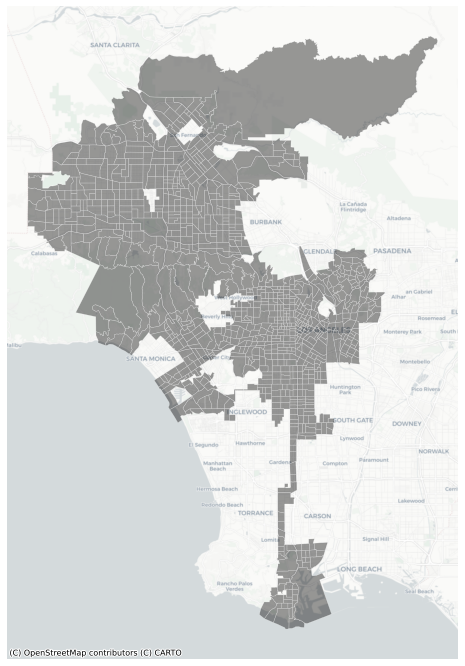

In [16]:
fig, ax = plt.subplots(figsize=(12,12))

gdf_tracts.plot(ax=ax,
         color='black', 
         edgecolor='white',
         lw=0.5,
         alpha=0.4)

# no axis
ax.axis('off')

# add a basemap
ctx.add_basemap(ax,source=ctx.providers.CartoDB.Positron)

bringing in our basemap and outlining the boundaries of our spatial scope 

## Bringing in our data on Toxic Release Sites in Los Angeles 

In [17]:
toxic_la_data = gpd.read_file('toxic_la_data.csv',GEOM_POSSIBLE_NAMES="geometry", KEEP_GEOM_COLUMNS="NO")

In [18]:
toxic_la_data = gpd.GeoDataFrame(toxic_la_data, 
                         crs='EPSG:4326',
                         geometry=gpd.points_from_xy(toxic_la_data.Longitude, toxic_la_data.Latitude))
toxic_la_data = toxic_la_data.to_crs(epsg=3857)
toxic_la_data['Latitude'] = toxic_la_data['Latitude'].astype(float)
toxic_la_data['Longitude'] = toxic_la_data['Longitude'].astype(float)

In [19]:
toxic_la_data


FID              industry_sector site_id  \
0      50                    Chemicals    5679   
1      54            Fabricated Metals    5985   
2      93                    Chemicals   11192   
3     137            Fabricated Metals   14904   
4     197            Fabricated Metals   18916   
..    ...                          ...     ...   
105  2724            Fabricated Metals  373020   
106  2836                         Food  549230   
107  2856              Hazardous Waste  549498   
108  2882  Nonmetallic Mineral Product  566340   
109  2922  Nonmetallic Mineral Product  575908   

                                 facility_name  \
0                          AMVAC CHEMICAL CORP   
1                     ANODIZING INDUSTRIES INC   
2    BAXALTA US INC., PART OF THE TAKEDA GROUP   
3                                  CAL METAL X   
4                      CHROMAL PLATING COMPANY   
..                                         ...   
105                     FANSTEEL CA DROP FORGE   
106                              REX CREAMERY.   
107                  INDUSTRIAL SERVICE OIL CO   
108            NATIONAL READY MIX CONCRETE CO.   
109                 CALPORTLAND COMPANY CONRAC   

                                     address         city state   Latitude  \
0                     4100 E WASHINGTON BLVD  LOS ANGELES    CA  34.009718   
1                         5222 ALHAMBRA AVE.  LOS ANGELES    CA  34.073860   
2                         4501 Colorado Blvd  Los Angeles    CA  34.141700   
3    366 E 58TH ST  ATTN PARCEL 5100-007-003  LOS ANGELES    CA  33.989680   
4                        1748 WORKMAN STREET  LOS ANGELES    CA  34.062584   
..                                       ...          ...   ...        ...   
105                        1033 ALHAMBRA AVE  LOS ANGELES    CA  34.061983   
106                         5743 SMITHWAY ST  LOS ANGELES    CA  34.007910   
107                          1700 SOUTH SOTO  LOS ANGELES    CA  34.018320   
108                           2626 E 26TH ST  LOS ANGELES    CA  34.014480   
109                           5500 W 98TH ST  LOS ANGELES    CA  33.947760   

      Longitude                           geometry  
0   -118.188154  POINT (-13156645.121 4030106.991)  
1   -118.171608  POINT (-13154803.229 4038723.937)  
2   -118.269800  POINT (-13165733.912 4047844.781)  
3   -118.268860  POINT (-13165629.272 4027416.386)  
4   -118.213792  POINT (-13159499.130 4037208.627)  
..          ...                                ...  
105 -118.234208  POINT (-13161771.784 4037127.839)  
106 -118.148640  POINT (-13152246.443 4029864.195)  
107 -118.219520  POINT (-13160136.768 4031262.220)  
108 -118.224330  POINT (-13160672.215 4030746.502)  
109 -118.377540  POINT (-13177727.474 4021789.626)  

[110 rows x 10 columns]

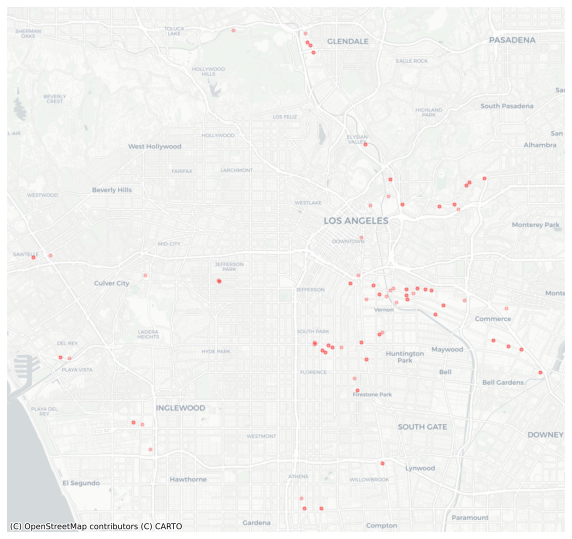

In [20]:
fig,ax = plt.subplots(figsize=(10,10))

toxic_la_data.plot(ax=ax,
             color='red',
             markersize=10, alpha=0.2)

# no axis
ax.axis('off')

# add a basemap
ctx.add_basemap(ax,source=ctx.providers.CartoDB.Positron)

In [50]:
#having concerns about our small data sample 

## Making our Map multilayered

In [21]:
minx, miny, maxx, maxy = toxic_la_data.geometry.total_bounds
print(minx)
print(maxx)
print(miny)
print(maxy)

-13185388.147558296
-13149876.562078297
4015901.2739372957
4049330.165396619


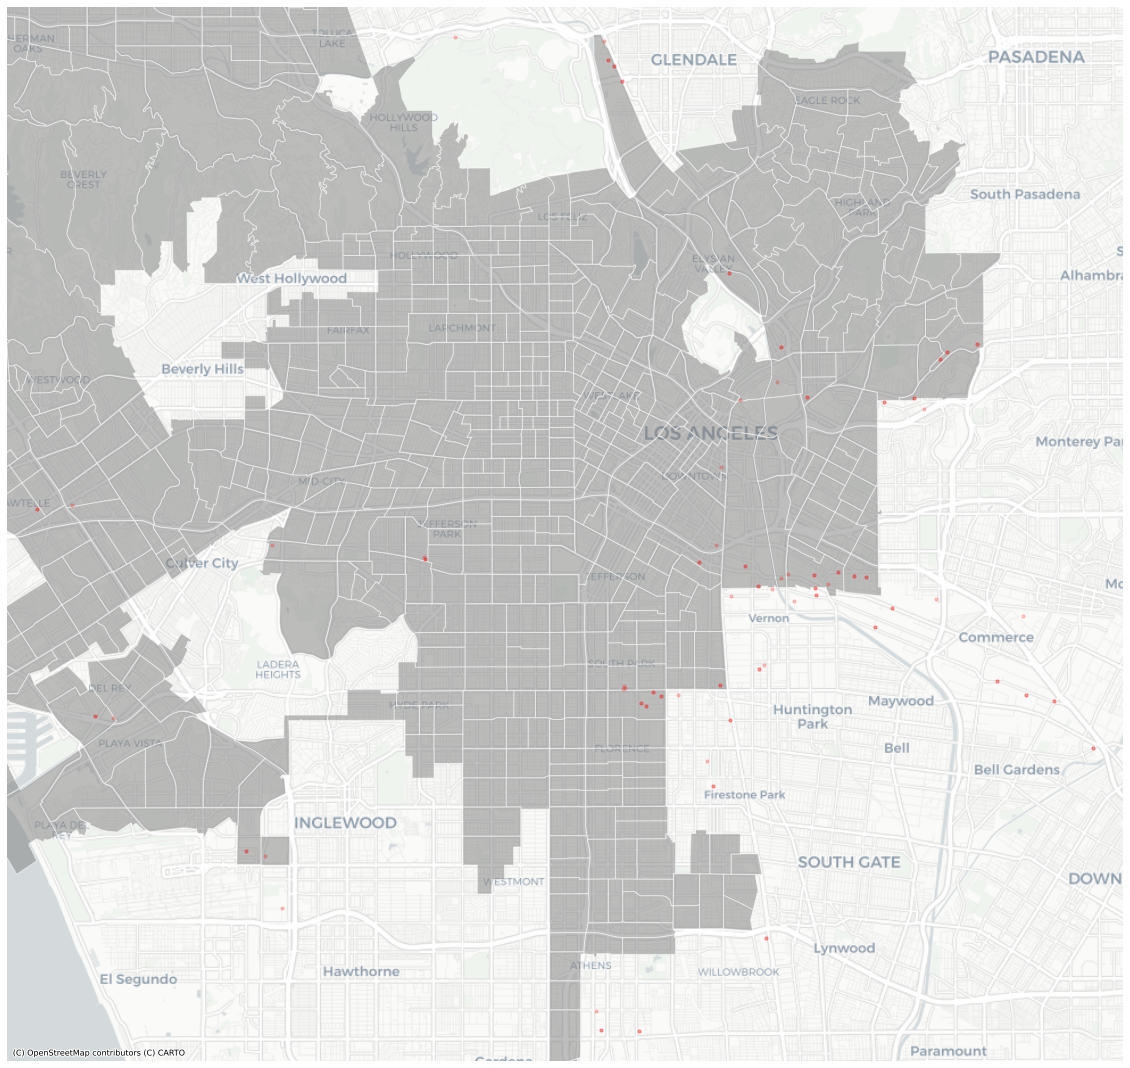

In [22]:
# set up the plot canvas with plt.subplots
fig, ax = plt.subplots(figsize=(20, 20))

# block groups
gdf_tracts.plot(ax=ax, # this puts it in the ax plot
        color='gray', 
        edgecolor='white',
        alpha=0.5)

# arrests
toxic_la_data.plot(ax=ax, # this also puts it in the same ax plot
            color='red',
            markersize=10,
            alpha=0.2)

# use the bounding box coordinates to set the x and y limits
ax.set_xlim(minx - 1000, maxx + 1000) # added/substracted value is to give some margin around total bounds
ax.set_ylim(miny - 1000, maxy + 1000)

# no axis
ax.axis('off')

# add a basemap
ctx.add_basemap(ax,source=ctx.providers.CartoDB.Positron)

In [51]:
#unfortunatley lost quite a few points that layed beyond the boundaries of Los Angeles :( 

## The Spatial Join !

In [23]:
# Do the spatial join
join = gpd.sjoin(toxic_la_data, gdf_tracts, how='left')
join.head()

FID    industry_sector site_id                              facility_name  \
0   50          Chemicals    5679                        AMVAC CHEMICAL CORP   
1   54  Fabricated Metals    5985                   ANODIZING INDUSTRIES INC   
2   93          Chemicals   11192  BAXALTA US INC., PART OF THE TAKEDA GROUP   
3  137  Fabricated Metals   14904                                CAL METAL X   
4  197  Fabricated Metals   18916                    CHROMAL PLATING COMPANY   

                                   address         city state   Latitude  \
0                   4100 E WASHINGTON BLVD  LOS ANGELES    CA  34.009718   
1                       5222 ALHAMBRA AVE.  LOS ANGELES    CA  34.073860   
2                       4501 Colorado Blvd  Los Angeles    CA  34.141700   
3  366 E 58TH ST  ATTN PARCEL 5100-007-003  LOS ANGELES    CA  33.989680   
4                      1748 WORKMAN STREET  LOS ANGELES    CA  34.062584   

    Longitude                           geometry  index_right  \
0 -118.188154  POINT (-13156645.121 4030106.991)          NaN   
1 -118.171608  POINT (-13154803.229 4038723.937)        505.0   
2 -118.269800  POINT (-13165733.912 4047844.781)        394.0   
3 -118.268860  POINT (-13165629.272 4027416.386)        724.0   
4 -118.213792  POINT (-13159499.130 4037208.627)        493.0   

                 FIPS  TotalPop  
0                 NaN       NaN  
1  14000US06037201602    2960.0  
2  14000US06037188100    3918.0  
3  14000US06037229410    3697.0  
4  14000US06037199900    2692.0

In [24]:
toxic_la_data_by_gdf = join.FIPS.value_counts().rename_axis('FIPS').reset_index(name='TRI_count')

In [25]:
toxic_la_data_by_gdf.head()

FIPS  TRI_count
0  14000US06037239202          8
1  14000US06037188100          7
2  14000US06037201602          6
3  14000US06037205120          6
4  14000US06037206031          4

TRI count shows us how many toxic facilities are located in that census tract labeled by "FIPS"

<AxesSubplot:xlabel='FIPS'>

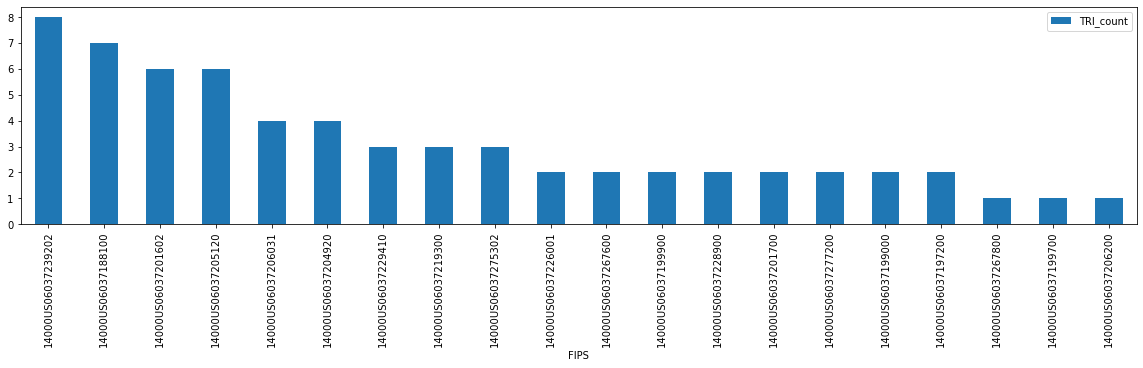

In [26]:
# make a bar chart of top 20 geographies
toxic_la_data_by_gdf[:20].plot.bar(figsize=(20,4),
                             x='FIPS',
                             y='TRI_count')

In [27]:
gdf_tracts=gdf_tracts.merge(toxic_la_data_by_gdf,on='FIPS')

I decided because the ratio of population to toxic facilities is smaller than the ration of population to number of arrests (like Yoh's lab) I would use a bigger number than 1000 so I tried 5000. I'm not sure of what a good measure would be and how to decide what quantity to use, but I hope that doesn't mess with my 

In [28]:
gdf_tracts['TRIs_per_5000'] = gdf_tracts['TRI_count']/gdf_tracts['TotalPop']*5000

In [29]:
gdf_tracts.sort_values(by="TRIs_per_5000").tail()

FIPS  TotalPop  \
19  14000US06037239202    5999.0   
7   14000US06037204920    2751.0   
8   14000US06037205120    3548.0   
0   14000US06037188100    3918.0   
5   14000US06037201602    2960.0   

                                             geometry  TRI_count  \
19  MULTIPOLYGON (((-13166193.439 4026564.006, -13...          8   
7   MULTIPOLYGON (((-13158279.625 4031441.786, -13...          4   
8   MULTIPOLYGON (((-13160215.471 4031563.603, -13...          6   
0   MULTIPOLYGON (((-13166684.247 4049392.313, -13...          7   
5   MULTIPOLYGON (((-13155419.160 4039190.557, -13...          6   

    TRIs_per_5000  
19       6.667778  
7        7.270084  
8        8.455468  
0        8.933129  
5       10.135135

## Next we will map the top 20 locations of Toxic Releases in Los Angeles

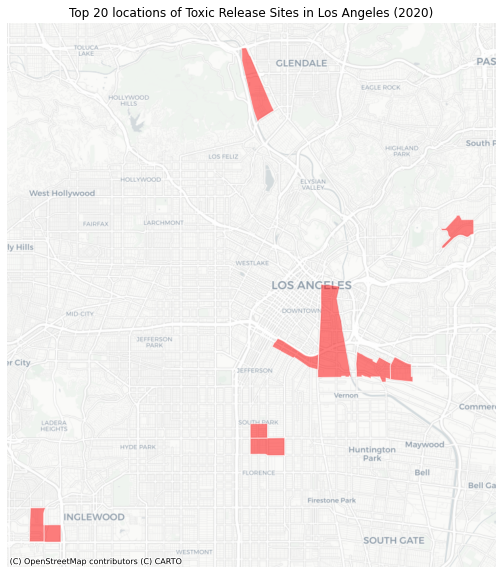

In [30]:
# map the top 20 geographies
fig,ax = plt.subplots(figsize=(12,10))
gdf_tracts.sort_values(by='TRIs_per_5000',ascending=False)[:10].plot(ax=ax,
                                                                 color='red',
                                                                 edgecolor='white',
                                                                 alpha=0.5,legend=True)


# title
ax.set_title('Top 20 locations of Toxic Release Sites in Los Angeles (2020)')

# no axis
ax.axis('off')

# add a basemap
ctx.add_basemap(ax,source=ctx.providers.CartoDB.Positron)

## Choropleth Map Time! 

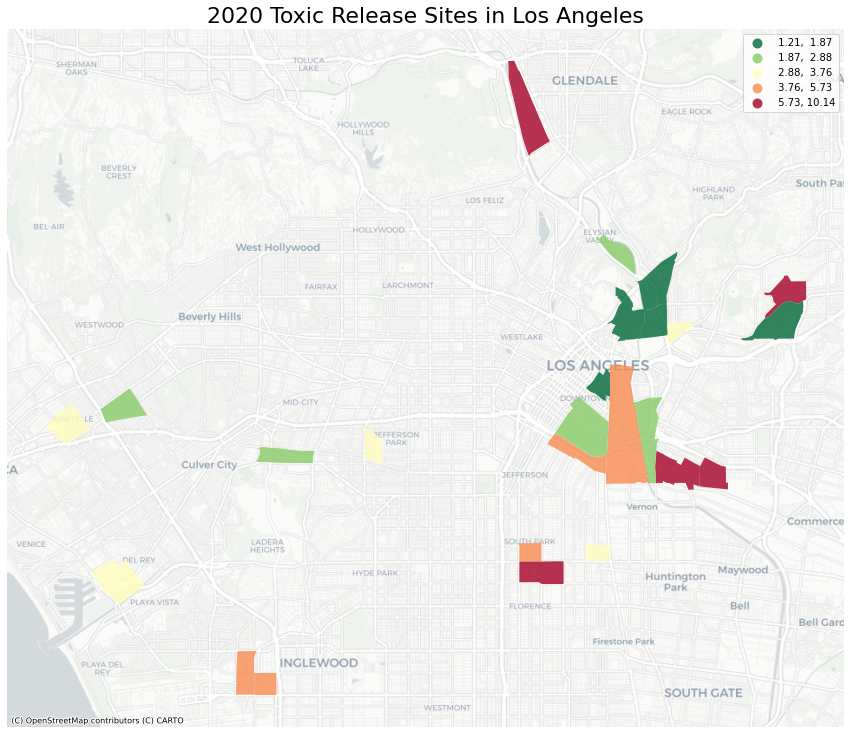

In [31]:
fig,ax = plt.subplots(figsize=(15,15))

gdf_tracts.plot(ax=ax,
        column='TRIs_per_5000',
        legend=True,
        alpha=0.8,
        cmap='RdYlGn_r',
        scheme='quantiles')

ax.axis('off')
ax.set_title('2020 Toxic Release Sites in Los Angeles',fontsize=22)
ctx.add_basemap(ax,source=ctx.providers.CartoDB.Positron)

I did not have a lot of data points so lots of empty space :( 


In [32]:
# calculate spatial weight
wq =  lps.weights.KNN.from_dataframe(gdf_tracts,k=8)

# Row-standardization
wq.transform = 'r'

In [33]:
gdf_tracts['TRIs_per_5000_lag'] = lps.weights.lag_spatial(wq, gdf_tracts['TRIs_per_5000'])

In [34]:
gdf_tracts.sample(10)[['FIPS','TotalPop','TRI_count','TRIs_per_5000','TRIs_per_5000_lag']]

FIPS  TotalPop  TRI_count  TRIs_per_5000  TRIs_per_5000_lag
2   14000US06037199000    5391.0          2       1.854943           3.097353
7   14000US06037204920    2751.0          4       7.270084           3.840187
4   14000US06037199900    2692.0          2       3.714710           2.203170
11  14000US06037206050    2031.0          1       2.461841           4.216890
15  14000US06037226001    2615.0          2       3.824092           4.238477
21  14000US06037267800    2666.0          1       1.875469           4.097842
12  14000US06037206200    4001.0          1       1.249688           3.611311
22  14000US06037275302    5059.0          3       2.965013           3.961649
20  14000US06037267600    2916.0          2       3.429355           3.903606
24  14000US06037277400     909.0          1       5.500550           3.644707

In [35]:
gdf_tracts['TRI_lag_diff'] = gdf_tracts['TRIs_per_5000'] - gdf_tracts['TRIs_per_5000_lag']

In [36]:
gdf_tracts.sort_values(by='TRI_lag_diff')

FIPS  TotalPop  \
12  14000US06037206200    4001.0   
21  14000US06037267800    2666.0   
6   14000US06037201700    5514.0   
14  14000US06037220100    2415.0   
11  14000US06037206050    2031.0   
17  14000US06037228900    2918.0   
9   14000US06037206010    4121.0   
1   14000US06037197200    3909.0   
2   14000US06037199000    5391.0   
22  14000US06037275302    5059.0   
3   14000US06037199700    3063.0   
16  14000US06037226002    1820.0   
20  14000US06037267600    2916.0   
15  14000US06037226001    2615.0   
18  14000US06037229410    3697.0   
13  14000US06037219300    4239.0   
23  14000US06037277200    2196.0   
10  14000US06037206031    4131.0   
4   14000US06037199900    2692.0   
24  14000US06037277400     909.0   
19  14000US06037239202    5999.0   
7   14000US06037204920    2751.0   
8   14000US06037205120    3548.0   
0   14000US06037188100    3918.0   
5   14000US06037201602    2960.0   

                                             geometry  TRI_count  \
12  MULTIPOLYGON (((-13163191.709 4035071.465, -13...          1   
21  MULTIPOLYGON (((-13184650.433 4034053.679, -13...          1   
6   MULTIPOLYGON (((-13156417.250 4037200.430, -13...          2   
14  MULTIPOLYGON (((-13177778.792 4031769.231, -13...          1   
11  MULTIPOLYGON (((-13161124.283 4034383.213, -13...          1   
17  MULTIPOLYGON (((-13163280.208 4028108.514, -13...          2   
9   MULTIPOLYGON (((-13162331.543 4037836.577, -13...          1   
1   MULTIPOLYGON (((-13162842.166 4041648.022, -13...          2   
2   MULTIPOLYGON (((-13160995.598 4039712.840, -13...          2   
22  MULTIPOLYGON (((-13185065.432 4026877.348, -13...          3   
3   MULTIPOLYGON (((-13160940.718 4037166.030, -13...          1   
16  MULTIPOLYGON (((-13164628.510 4033003.746, -13...          1   
20  MULTIPOLYGON (((-13187066.512 4033274.414, -13...          2   
15  MULTIPOLYGON (((-13164885.880 4032643.760, -13...          2   
18  MULTIPOLYGON (((-13166195.665 4028161.147, -13...          3   
13  MULTIPOLYGON (((-13173003.186 4033177.429, -13...          3   
23  MULTIPOLYGON (((-13178665.897 4021733.801, -13...          2   
10  MULTIPOLYGON (((-13162384.420 4030801.699, -13...          4   
4   MULTIPOLYGON (((-13159729.895 4037317.337, -13...          2   
24  MULTIPOLYGON (((-13177853.933 4022331.510, -13...          1   
19  MULTIPOLYGON (((-13166193.439 4026564.006, -13...          8   
7   MULTIPOLYGON (((-13158279.625 4031441.786, -13...          4   
8   MULTIPOLYGON (((-13160215.471 4031563.603, -13...          6   
0   MULTIPOLYGON (((-13166684.247 4049392.313, -13...          7   
5   MULTIPOLYGON (((-13155419.160 4039190.557, -13...          6   

    TRIs_per_5000  TRIs_per_5000_lag  TRI_lag_diff  
12       1.249688           3.611311     -2.361624  
21       1.875469           4.097842     -2.222373  
6        1.813565           3.855075     -2.041509  
14       2.070393           4.073477     -2.003083  
11       2.461841           4.216890     -1.755049  
17       3.427005           5.040663     -1.613658  
9        1.213298           2.632558     -1.419260  
1        2.558199           3.818357     -1.260158  
2        1.854943           3.097353     -1.242409  
22       2.965013           3.961649     -0.996636  
3        1.632387           2.463461     -0.831074  
16       2.747253           3.388153     -0.640900  
20       3.429355           3.903606     -0.474251  
15       3.824092           4.238477     -0.414386  
18       4.057344           4.209321     -0.151977  
13       3.538570           3.610624     -0.072054  
23       4.553734           3.763059      0.790675  
10       4.841443           3.606764      1.234679  
4        3.714710           2.203170      1.511540  
24       5.500550           3.644707      1.855843  
19       6.667778           3.883017      2.784761  
7        7.270084           3.840187      3.429896  
8        8.455468           3.692014      4.763453  
0        8.933129           3.138202    

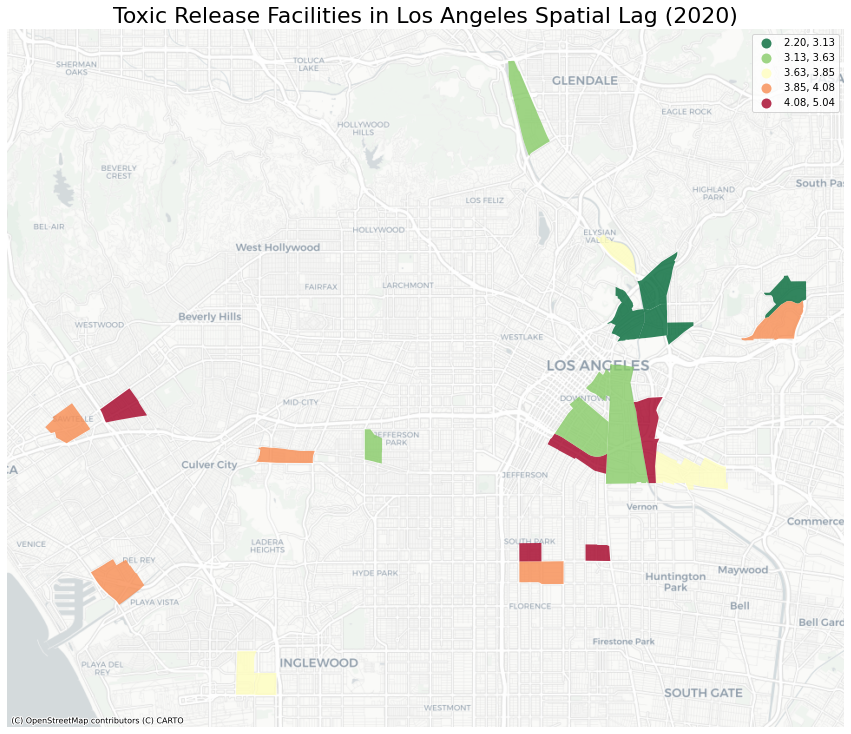

In [53]:
# use subplots that make it easier to create multiple layered maps
fig, ax = plt.subplots(figsize=(15, 15))

# spatial lag choropleth
gdf_tracts.plot(ax=ax,
         figsize=(15,15),
         column='TRIs_per_5000_lag',
         legend=True,
         alpha=0.8,
         cmap='RdYlGn_r',
         scheme='quantiles')

ax.axis('off')
ax.set_title('Toxic Release Facilities in Los Angeles Spatial Lag (2020)',fontsize=22)

ctx.add_basemap(ax,source=ctx.providers.CartoDB.Positron)

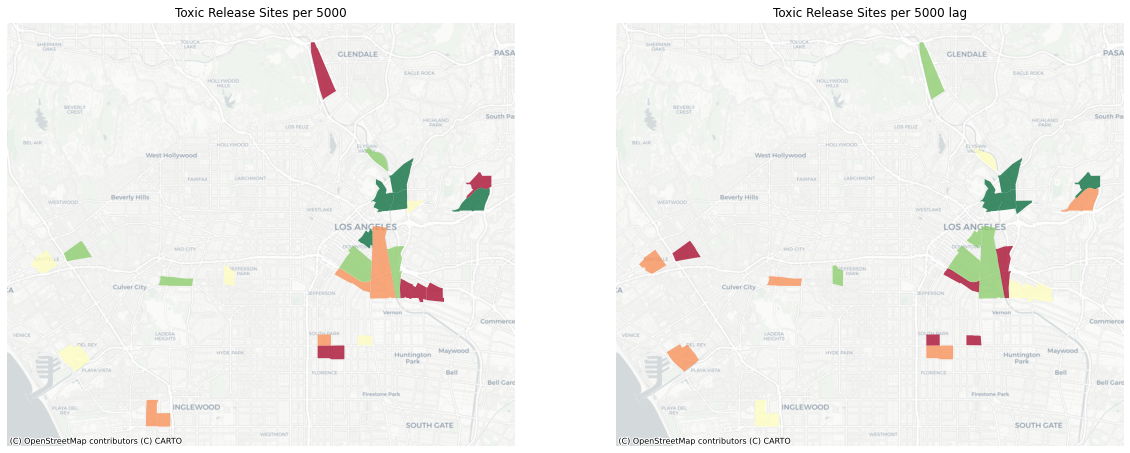

In [54]:
# create the 1x2 subplots
fig, ax = plt.subplots(1, 2, figsize=(20, 12))

# two subplots produces ax[0] (left) and ax[1] (right)

# regular count map on the left
gdf_tracts.plot(ax=ax[0], # this assigns the map to the left subplot
         column='TRIs_per_5000', 
         cmap='RdYlGn_r', 
         scheme='quantiles',
         k=5, 
         edgecolor='white', 
         linewidth=0, 
         alpha=0.75, 
           )


ax[0].axis("off")
ax[0].set_title("Toxic Release Sites per 5000")

# spatial lag map on the right
gdf_tracts.plot(ax=ax[1], # this assigns the map to the right subplot
         column='TRIs_per_5000_lag', 
         cmap='RdYlGn_r', 
         scheme='quantiles',
         k=5, 
         edgecolor='white', 
         linewidth=0, 
         alpha=0.75
           )

ax[1].axis("off")
ax[1].set_title("Toxic Release Sites per 5000 lag")

ctx.add_basemap(ax[0],source=ctx.providers.CartoDB.Positron)
ctx.add_basemap(ax[1],source=ctx.providers.CartoDB.Positron)

#plt.show()

With the spatial lag we can see that many previously red areas have turned to green, smoothed out to due to the values 
of its neighbors. Some areas that had been strongly red next to areas srtrongly green smoothed out to in between colors. If the numbers had been significanly high and its neighbors would have been significantly low, we would have not seen the smoothing out of the spatial lag. 

# Morans Plot 

In [39]:
y = gdf_tracts.TRIs_per_5000
moran = Moran(y, wq)
moran.I

-0.021117473394748208

In [40]:
moran.p_sim

0.288

In [41]:
# calculate local moran values
lisa = esda.moran.Moran_Local(y, wq)

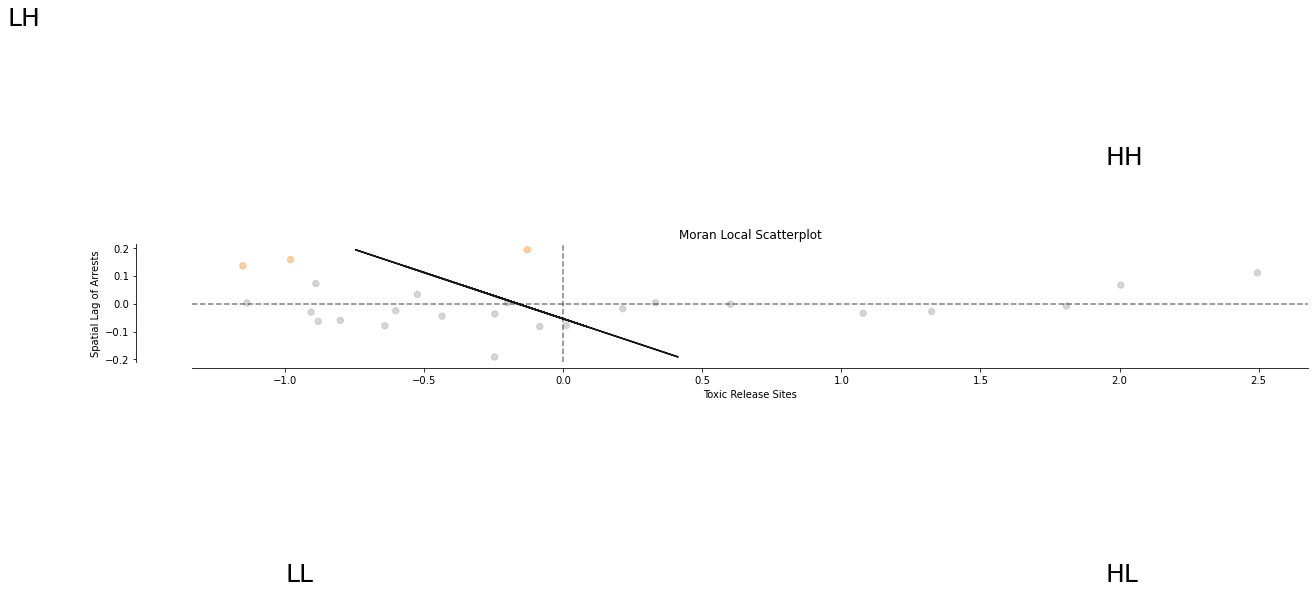

In [42]:
fig,ax = plt.subplots(figsize=(20,15))

moran_scatterplot(lisa, ax=ax, p=0.05)
ax.set_xlabel("Toxic Release Sites")
ax.set_ylabel('Spatial Lag of Arrests')

# add some labels
plt.text(1.95, 0.5, "HH", fontsize=25)
plt.text(1.95, -1, "HL", fontsize=25)
plt.text(-2, 1, "LH", fontsize=25)
plt.text(-1, -1, "LL", fontsize=25)
plt.show()


 There is a negative spatial autocorrelation between amount of toxic release sites in neighborhoods and their locations.

## Spatial Autocorrelation Map

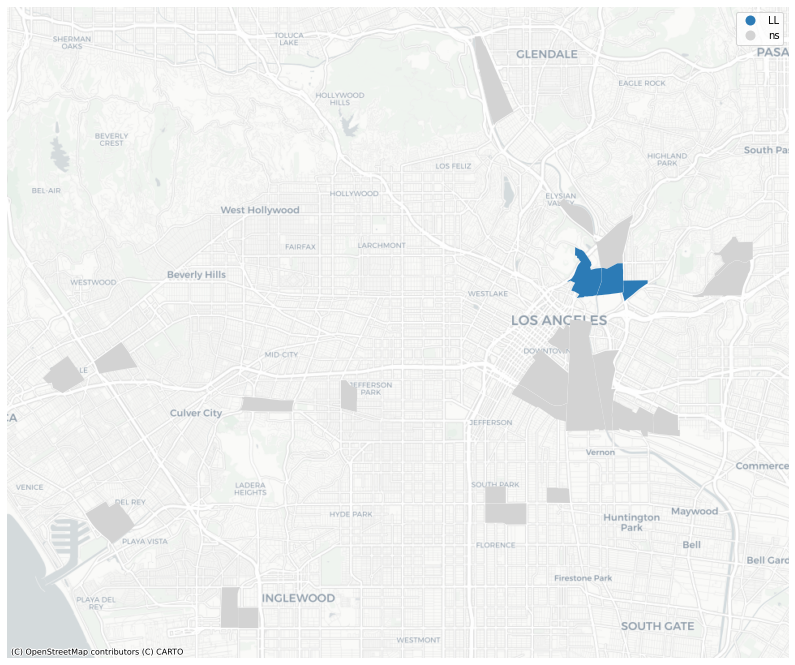

In [47]:
fig, ax = plt.subplots(figsize=(14,12))
lisa_cluster(lisa, gdf_tracts, p=0.05, ax=ax)


ctx.add_basemap(ax,source=ctx.providers.CartoDB.Positron)
#plt.show()



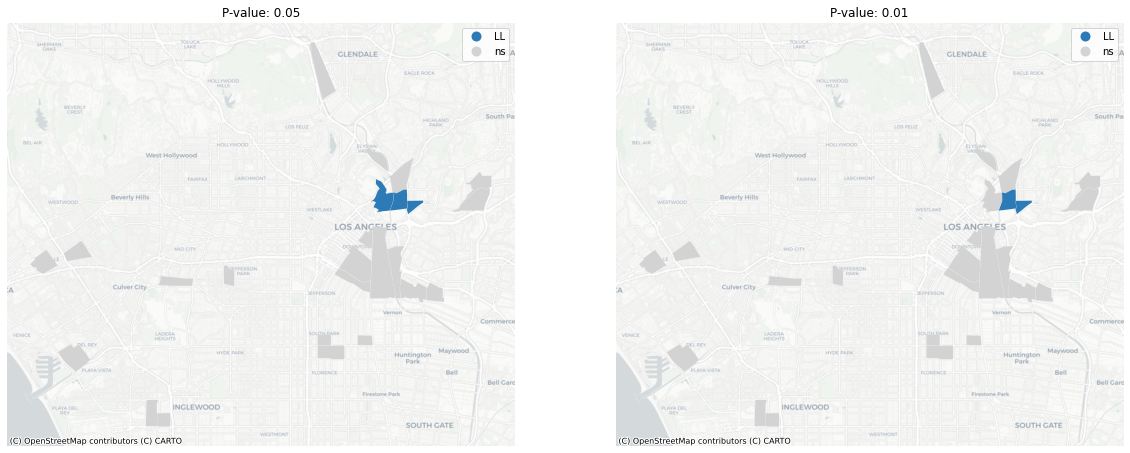

In [48]:
# create the 1x2 subplots
fig, ax = plt.subplots(1, 2, figsize=(20, 12))

# regular count map on the left
lisa_cluster(lisa,gdf_tracts, p=0.05, ax=ax[0])

ax[0].axis("off")
ax[0].set_title("P-value: 0.05")

# spatial lag map on the right
lisa_cluster(lisa,gdf_tracts, p=0.01, ax=ax[1])
ax[1].axis("off")
ax[1].set_title("P-value: 0.01")


ctx.add_basemap(ax[0],source=ctx.providers.CartoDB.Positron)
ctx.add_basemap(ax[1],source=ctx.providers.CartoDB.Positron)

#plt.show()

It appears that despite there being a previous cluster in East LA in the location of toxic sites we see that there is no statistical significance in the placement of toxic release sites in proportion to population, except for the two areas shown above with a significe in Low amount of Toxic sites next to Low amount of Toxic Sites within P-values of 0.05 and 0.01. This shows that this pattern is not random and there appears to lower than average amount of toxic facilites surrouned by neighborhoods that also have lower amount of toxic sites. However this pattern is not seen throughout Los Angeles and is concentrated in a small area. I think as we move forward we want to explore distances to residential areas, Antonia is creating a function and a loop in order to explore the toxic sites proximity to residential areas and other types of buildings within a 1 mile radius. We plan to look at how this is similar or different to other surrounding areas. We also hope to incorporate health effects/amount of toxic chemicals released by the toxic sites and continue to look at any statisfical signicance/ or lack thereof between the aforementioned variables. 